In [1]:
%ls /kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/

TCGA_DU_7019_19940908_1.tif        TCGA_DU_7019_19940908_27_mask.tif
TCGA_DU_7019_19940908_10.tif       TCGA_DU_7019_19940908_28.tif
TCGA_DU_7019_19940908_10_mask.tif  TCGA_DU_7019_19940908_28_mask.tif
TCGA_DU_7019_19940908_11.tif       TCGA_DU_7019_19940908_29.tif
TCGA_DU_7019_19940908_11_mask.tif  TCGA_DU_7019_19940908_29_mask.tif
TCGA_DU_7019_19940908_12.tif       TCGA_DU_7019_19940908_2_mask.tif
TCGA_DU_7019_19940908_12_mask.tif  TCGA_DU_7019_19940908_3.tif
TCGA_DU_7019_19940908_13.tif       TCGA_DU_7019_19940908_30.tif
TCGA_DU_7019_19940908_13_mask.tif  TCGA_DU_7019_19940908_30_mask.tif
TCGA_DU_7019_19940908_14.tif       TCGA_DU_7019_19940908_31.tif
TCGA_DU_7019_19940908_14_mask.tif  TCGA_DU_7019_19940908_31_mask.tif
TCGA_DU_7019_19940908_15.tif       TCGA_DU_7019_19940908_32.tif
TCGA_DU_7019_19940908_15_mask.tif  TCGA_DU_7019_19940908_32_mask.tif
TCGA_DU_7019_19940908_16.tif       TCGA_DU_7019_19940908_33.tif
TCGA_DU_7019_19940908_16_mask.tif  TCGA_DU_7019_19940908_33_mask.tif
TC

In [2]:


import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline  
import glob  # Filename pattern matching
import random  
import cv2  # Computer vision
from PIL import Image  # Image processing

import torch  
import torchvision  # Computer vision tools
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # Neural network functions
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as tt  # Image transformations
import albumentations as A  # Image augmentations
from tqdm import tqdm  # Progress bar
from mpl_toolkits.axes_grid1 import ImageGrid  # Image grid layout
from torch.utils.data import DataLoader  # Data loading
from torchvision.utils import make_grid  # Create image grids
from sklearn.model_selection import train_test_split  



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Select GPU if available, otherwise CPU
print("Using {} device".format(device))  # Print the selected device

Using cuda device


In [4]:


def set_seed(seed=0):  # Function to set random seed for reproducibility
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  
    torch.manual_seed(seed)  # 
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed)  
    random.seed(seed)  

set_seed() 



In [5]:


ROOT_PATH = '../input/lgg-mri-segmentation/kaggle_3m/'

# Using glob.glob to collect paths of all mask files in subdirectories 
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

# Defining a function diagnosis(mask_path) that returns 1 
#if the maximum pixel value in the mask image (read using cv2) is greater than 0
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df



,image_path,mask_path,diagnosis
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
...,...,...,...
3924,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3925,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3926,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3927,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0


In [6]:
print("Total of No Tumor:", files_df['diagnosis'].value_counts()[0])
print("Total of Tumor:", files_df['diagnosis'].value_counts()[1])

Total of No Tumor: 2556
Total of Tumor: 1373


(3005, 3) (393, 3) (531, 3)


(-0.5, 1279.5, 255.5, -0.5)

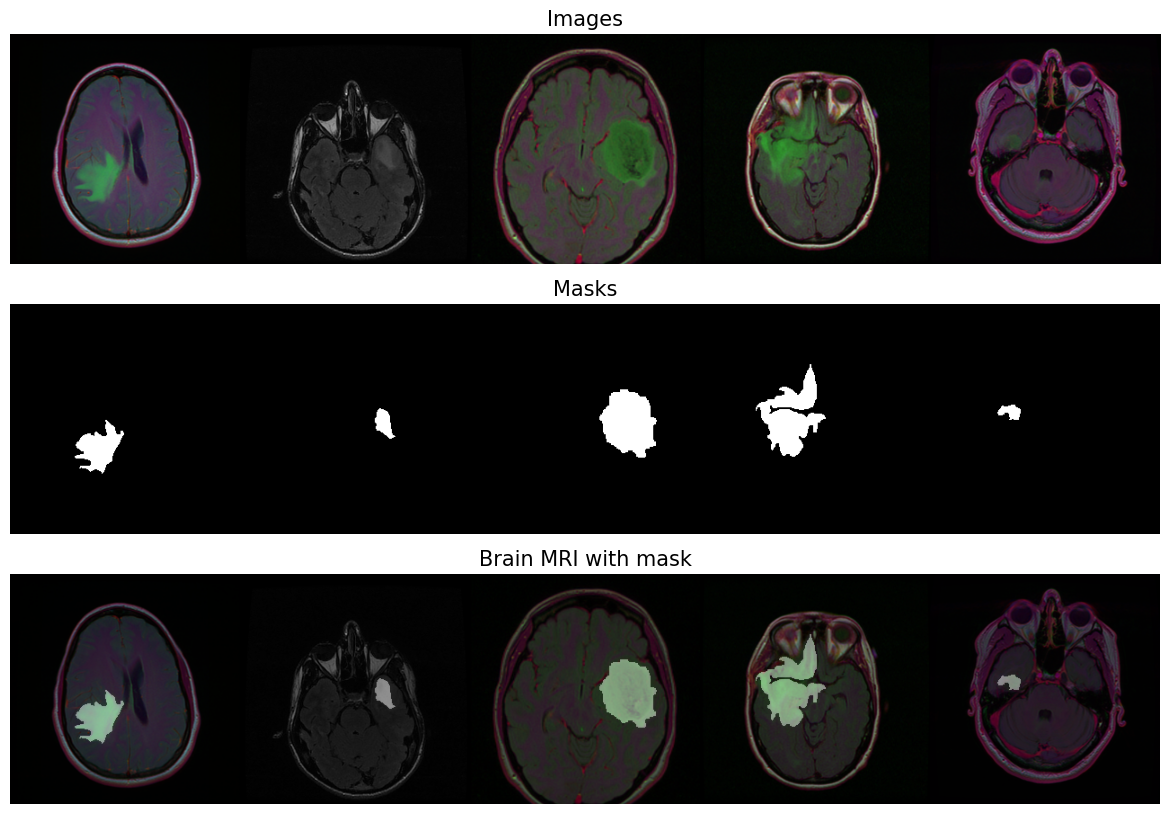

In [7]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.shape, val_df.shape, test_df.shape)

set_seed()
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')



In [8]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

In [9]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
])


In [10]:
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [11]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [12]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)


Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-23 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-19 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



In [13]:
batch_size = 64

# Set seed for reproducibility in random operations.
set_seed()
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
set_seed()
val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)
test_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [14]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv(x)

class XNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(XNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)

        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XNet

In [15]:
model = XNet(3, 1).to(device)

In [16]:
# execute a forward pass
output = model(torch.randn(1, 3, 128, 128).to(device))
print(output.shape)

torch.Size([1, 1, 128, 128])


In [17]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

# Function to calculate the Dice coefficient loss between prediction and ground truth.
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate the combined BCE (Binary Cross Entropy) and Dice loss.
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss



In [18]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def train_loop(model, loader, loss_func, optimizer):
    model.train()
    train_losses = []
    train_dices = []
    all_preds = []
    all_masks = []

    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)

        # Convert outputs to numpy array for post-processing
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        mask_np = mask.data.cpu().numpy()

        dice = dice_coef_metric(out_cut, mask_np)
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        all_preds.extend(out_cut.flatten())
        all_masks.extend(mask_np.flatten())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_f1 = f1_score(all_masks, all_preds, average='weighted')
    train_accuracy = accuracy_score(all_masks, all_preds)

    return np.mean(train_dices), np.mean(train_losses), train_f1, train_accuracy


In [19]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [21]:
def eval_loop(model, loader, loss_func, device):
    model.eval()
    val_loss = 0
    val_dice = 0
    val_f1 = 0
    all_preds = []
    all_masks = []
    
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)
            outputs = model(image)
            loss = loss_func(outputs, mask)
            
            # Move the loss tensor to CPU before converting to numpy
            loss_cpu = loss.cpu()
            
            # Convert outputs to numpy array for post-processing
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            mask_np = mask.data.cpu().numpy()
            
            dice = dice_coef_metric(out_cut, mask_np)
            f1 = f1_score(mask_np.flatten(), out_cut.flatten(), average='weighted')
            
            val_loss += loss_cpu.item()
            val_dice += dice
            val_f1 += f1
            
            all_preds.extend(out_cut.flatten())
            all_masks.extend(mask_np.flatten())
        
        val_mean_dice = val_dice / (step + 1)
        val_mean_loss = val_loss / (step + 1)
        val_mean_f1 = val_f1 / (step + 1)
        
        val_accuracy = accuracy_score(all_masks, all_preds)
        val_roc_auc = roc_auc_score(all_masks, all_preds)
        
    return val_mean_dice, val_mean_loss, val_mean_f1, val_roc_auc, val_accuracy


In [22]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs, model, device):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []
    train_f1_history = []
    val_f1_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        train_mean_dice, train_mean_loss, train_f1, train_accuracy = train_loop(model, train_loader, loss_func, optimizer)
        val_mean_dice, val_mean_loss, val_f1, val_roc_auc, val_accuracy = eval_loop(model, val_loader, loss_func, device)

        train_loss_history.append(train_mean_loss)
        train_dice_history.append(train_mean_dice)
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)
        train_f1_history.append(train_f1)
        val_f1_history.append(val_f1)
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_mean_loss:.3f}, Val Loss: {val_mean_loss:.3f}, Train DICE: {train_mean_dice:.3f}, Val DICE: {val_mean_dice:.3f}, Train F1: {train_f1:.3f}, Val F1: {val_f1:.3f}')

        if scheduler:
            scheduler.step(val_mean_dice)

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history, train_f1_history, val_f1_history, train_accuracy_history, val_accuracy_history


In [23]:
# Define the optimizer with Adam optimizer and initial learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate scheduler with ReduceLROnPlateau, monitoring 'max' validation metric, and patience of 3 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Number of epochs for training
num_epochs = 25

In [24]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report

In [25]:
train_loss_history, train_dice_history, val_loss_history, val_dice_history, train_f1_history, val_f1_history, train_accuracy_history, val_accuracy_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs, model, device)


Epoch: 1/25 | Train Loss: 1.156, Val Loss: 1.093, Train DICE: 0.477, Val DICE: 0.326, Train F1: 0.984, Val F1: 0.973
Epoch: 2/25 | Train Loss: 0.876, Val Loss: 0.862, Train DICE: 0.586, Val DICE: 0.449, Train F1: 0.991, Val F1: 0.985
Epoch: 3/25 | Train Loss: 0.616, Val Loss: 1.011, Train DICE: 0.632, Val DICE: 0.217, Train F1: 0.992, Val F1: 0.953
Epoch: 4/25 | Train Loss: 0.456, Val Loss: 0.673, Train DICE: 0.655, Val DICE: 0.452, Train F1: 0.993, Val F1: 0.983
Epoch: 5/25 | Train Loss: 0.377, Val Loss: 0.341, Train DICE: 0.691, Val DICE: 0.716, Train F1: 0.994, Val F1: 0.994
Epoch: 6/25 | Train Loss: 0.368, Val Loss: 0.548, Train DICE: 0.686, Val DICE: 0.512, Train F1: 0.994, Val F1: 0.991
Epoch: 7/25 | Train Loss: 0.341, Val Loss: 0.452, Train DICE: 0.707, Val DICE: 0.600, Train F1: 0.994, Val F1: 0.992
Epoch: 8/25 | Train Loss: 0.325, Val Loss: 0.338, Train DICE: 0.719, Val DICE: 0.719, Train F1: 0.994, Val F1: 0.994
Epoch: 9/25 | Train Loss: 0.314, Val Loss: 0.266, Train DICE: 0.

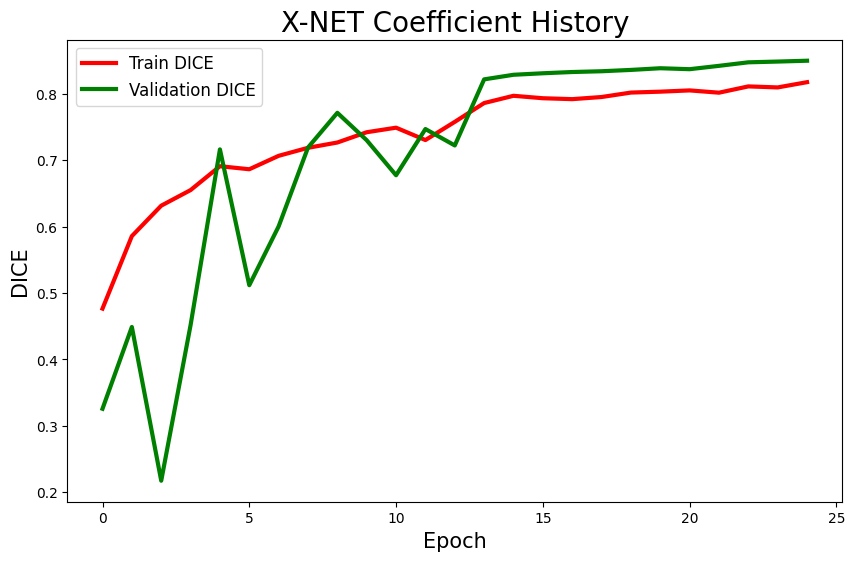

In [26]:
# Function to plot Dice coefficient history across epochs.
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="r")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="g")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
# Example usage to plot Dice coefficient history for a UNet model
plot_dice_history('X-NET Coefficient History', train_dice_history, val_dice_history, num_epochs)

In [27]:
test_dice, test_loss, test_f1, test_auc, test_accuracy = eval_loop(model, test_dl, bce_dice_loss, device)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))
print(f"F1 Score: {test_f1:.3f}")
print(f"ROC AUC Score: {test_auc:.3f}")
print(f"Accuracy Score: {test_accuracy:.3f}")


Mean IoU/DICE: 84.982%, Loss: 0.173
F1 Score: 0.997
ROC AUC Score: 0.915
Accuracy Score: 0.997


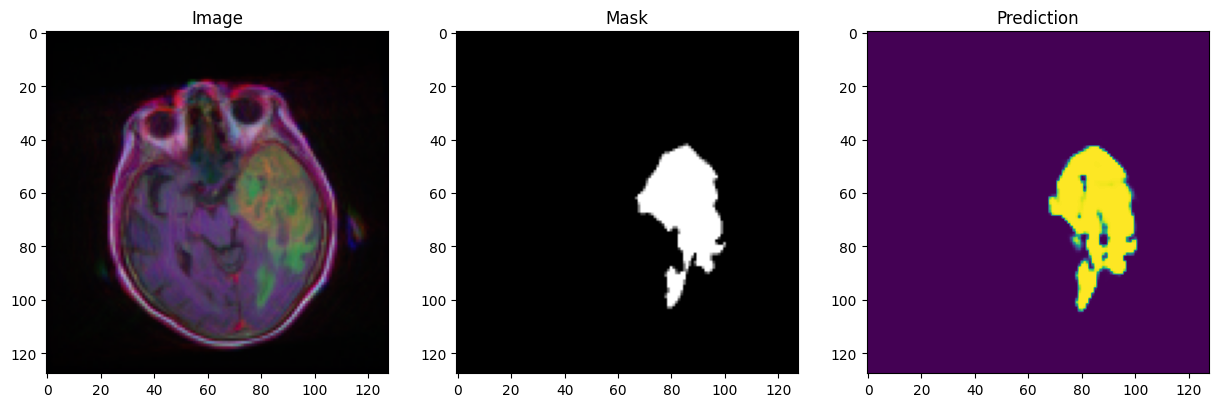

In [28]:
# Select a sample from the test set with diagnosis label 1 and resize image and mask
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Prediction
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[2].imshow(pred)
ax[2].set_title("Prediction")

plt.show()

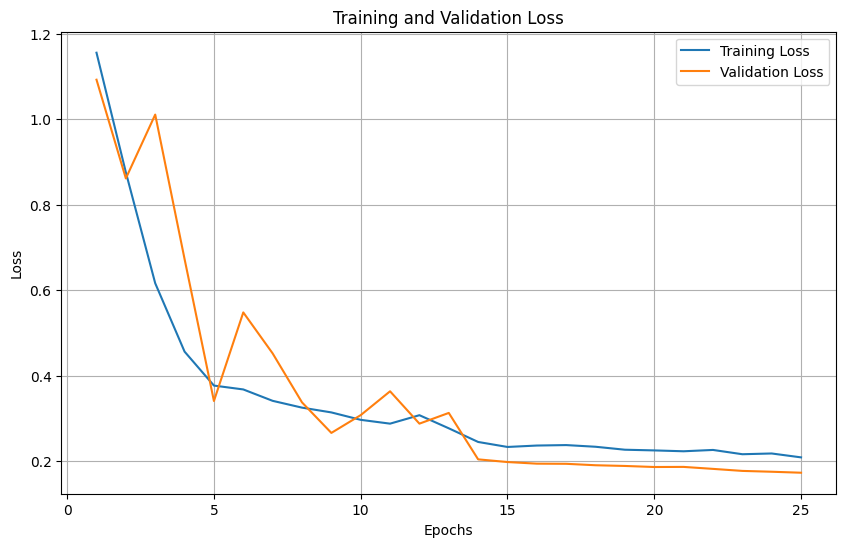

In [29]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
torch.save(model.state_dict(), 'xnet_model_state_dict.pth')
